In [52]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import Grouper
from pandas.plotting import lag_plot
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

#import pmdarima as pm

In [53]:
#Quarter 1
dataset_2016_Q1 = pd.read_csv('Datasets/quarter1/Divvy_Trips_2016_Q1.csv')
#Quarter 2 
dataset_2016_04  = pd.read_csv('Datasets/quarter2/Divvy_Trips_2016_04.csv')
dataset_2016_05  = pd.read_csv('Datasets/quarter2/Divvy_Trips_2016_05.csv')
dataset_2016_06  = pd.read_csv('Datasets/quarter2/Divvy_Trips_2016_06.csv')
dataset_2016_Q2 = pd.concat([dataset_2016_04, dataset_2016_05, dataset_2016_06])
#Quarter 3 
dataset_2016_Q3 = pd.read_csv('Datasets/quarter3/Divvy_Trips_2016_Q3.csv')
#Quarter 4 
dataset_2016_Q4 = pd.read_csv('Datasets/quarter4/Divvy_Trips_2016_Q4.csv')


In [54]:
dataset_2016_Q1['starttime'] = pd.to_datetime(dataset_2016_Q1['starttime'],infer_datetime_format=True)
dataset_2016_Q1['stoptime'] = pd.to_datetime(dataset_2016_Q1['stoptime'],infer_datetime_format=True)
dataset_2016_Q2['starttime'] = pd.to_datetime(dataset_2016_Q2['starttime'],infer_datetime_format=True)
dataset_2016_Q2['stoptime']  = pd.to_datetime(dataset_2016_Q2['stoptime'],infer_datetime_format=True)
dataset_2016_Q3['starttime'] = pd.to_datetime(dataset_2016_Q3['starttime'],infer_datetime_format=True)
dataset_2016_Q3['stoptime']  = pd.to_datetime(dataset_2016_Q3['stoptime'],infer_datetime_format=True)
dataset_2016_Q4['starttime'] = pd.to_datetime(dataset_2016_Q4['starttime'],infer_datetime_format=True)
dataset_2016_Q4['stoptime']  = pd.to_datetime(dataset_2016_Q4['stoptime'],infer_datetime_format=True)

In [55]:
dataset_2016_full=pd.concat([dataset_2016_Q1,dataset_2016_Q2,dataset_2016_Q3,dataset_2016_Q4])

In [56]:
data_2016 = pd.DataFrame(dataset_2016_full.groupby(dataset_2016_full['starttime'].dt.date).count()['trip_id'])
data_2016.columns = ['checkout']

In [57]:
data_2016.head()

,checkout
starttime,
2016-01-01,935
2016-01-02,1421
2016-01-03,1399
2016-01-04,3833
2016-01-05,4189


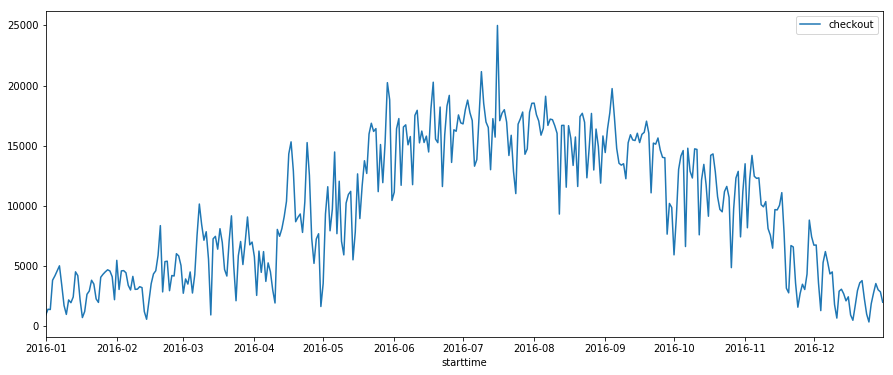

In [58]:
data_2016.plot()
plt.show()

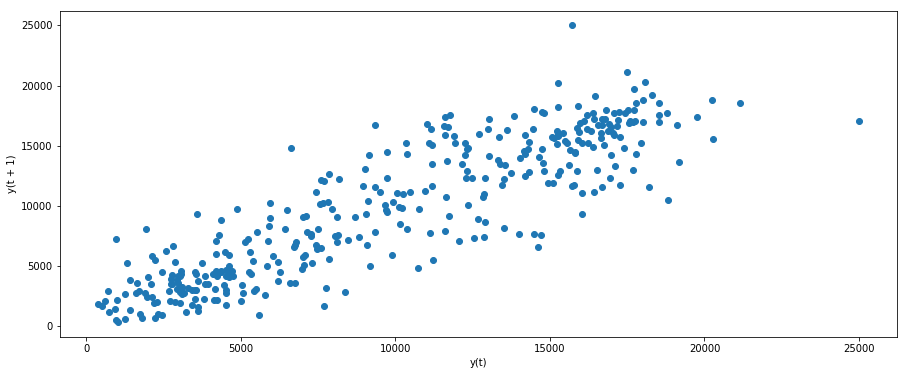

In [59]:
lag_plot(data_2016)
plt.show()

In [60]:

# correlation 
values = pd.DataFrame(data_2016.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t-1       t+1
t-1  1.000000  0.881948
t+1  0.881948  1.000000


# autocorrelation_plot

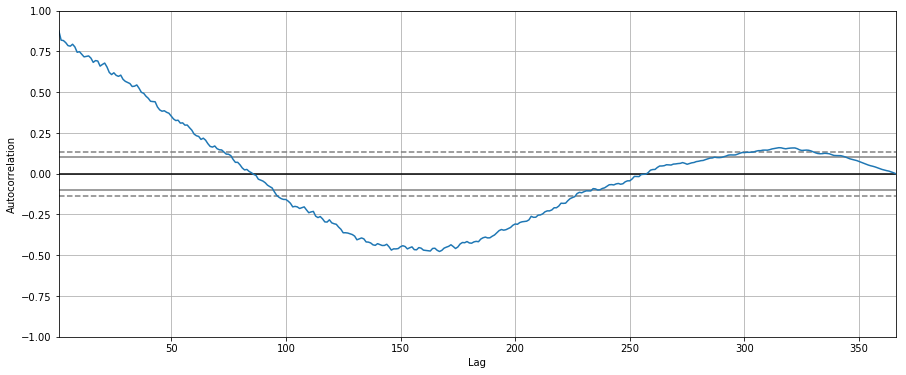

In [61]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data_2016)
plt.show()

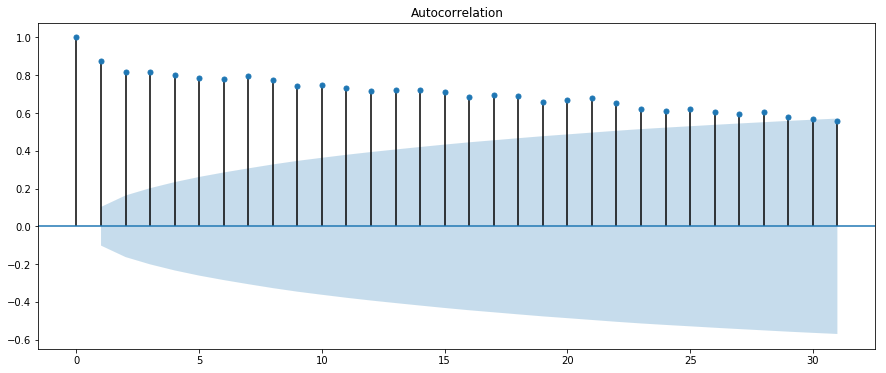

In [62]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data_2016, lags=31)
plt.show()

Test MSE: 6890998.810


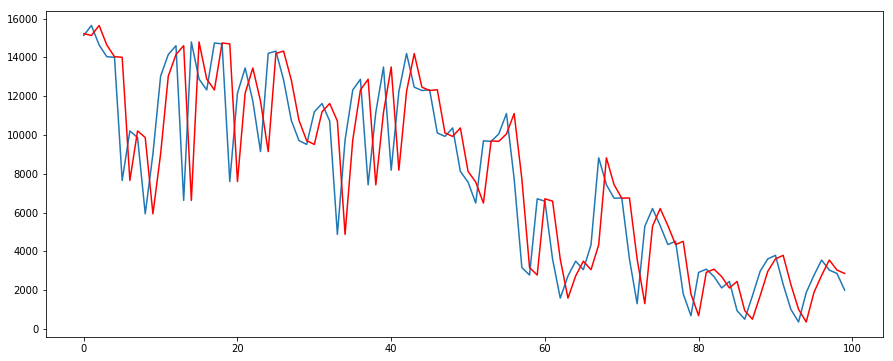

In [63]:

from sklearn.metrics import mean_squared_error
values = pd.DataFrame(data_2016.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-100], X[len(X)-100:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='red')
plt.show()

Lag: 15
Coefficients: [ 6.24346446e+02  4.54604331e-01 -2.31401796e-02  1.48699696e-01
  3.29132296e-02  4.25702979e-02 -2.72868233e-02  1.55097864e-01
  6.64443871e-02 -5.92314028e-02  6.82065830e-02 -3.07225954e-02
  1.06083214e-02  6.94886801e-02  4.64517406e-03  4.95716787e-02]
predicted=15309.430634, expected=15131.000000
predicted=14763.829881, expected=15644.000000
predicted=15050.790968, expected=14638.000000
predicted=15323.261167, expected=14034.000000
predicted=15674.797188, expected=14004.000000
predicted=14856.636582, expected=7657.000000
predicted=14884.147754, expected=10208.000000
predicted=15564.539908, expected=9871.000000
predicted=15122.424163, expected=5938.000000
predicted=15416.073426, expected=9023.000000
predicted=15480.543130, expected=13033.000000
predicted=15240.045055, expected=14147.000000
predicted=15318.610610, expected=14601.000000
predicted=15054.749110, expected=6629.000000
predicted=15265.702004, expected=14795.000000
predicted=15299.340034, expected

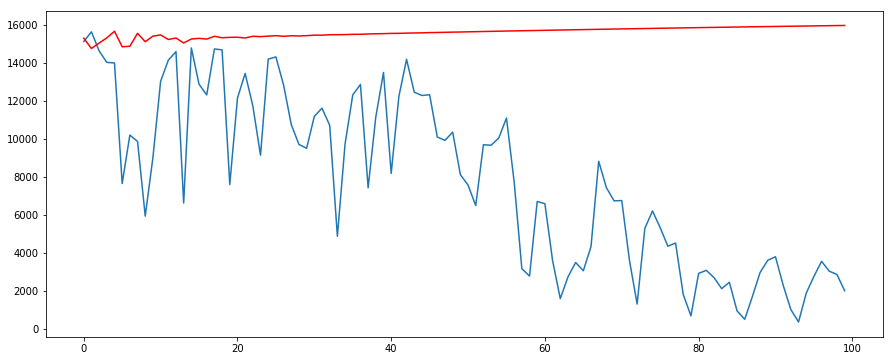

In [64]:

from statsmodels.tsa.ar_model import AR


# split dataset
X = data_2016.values
train, test = X[1:len(X)-100], X[len(X)-100:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
error_2 = mean_absolute_error(test, predictions)
print('Absoulte error',error_2)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## For Q1 all years , station =91

In [65]:
#Quarter 1
dataset_2015_Q1 = pd.read_csv('Datasets/quarter1/Divvy_Trips_2015_Q1.csv')
dataset_2016_Q1 = pd.read_csv('Datasets/quarter1/Divvy_Trips_2016_Q1.csv')
dataset_2017_Q1 = pd.read_csv('Datasets/quarter1/Divvy_Trips_2017_Q1.csv')
dataset_2018_Q1 = pd.read_csv('Datasets/quarter1/Divvy_Trips_2018_Q1.csv')



In [66]:
dataset_2015_Q1['starttime'] = pd.to_datetime(dataset_2015_Q1['starttime'],infer_datetime_format=True)
dataset_2015_Q1['stoptime'] = pd.to_datetime(dataset_2015_Q1['stoptime'],infer_datetime_format=True)

dataset_2016_Q1['starttime'] = pd.to_datetime(dataset_2016_Q1['starttime'],infer_datetime_format=True)
dataset_2016_Q1['stoptime'] = pd.to_datetime(dataset_2016_Q1['stoptime'],infer_datetime_format=True)

dataset_2017_Q1['starttime'] = pd.to_datetime(dataset_2017_Q1['starttime'],infer_datetime_format=True)
dataset_2017_Q1['stoptime'] = pd.to_datetime(dataset_2017_Q1['stoptime'],infer_datetime_format=True)

dataset_2018_Q1['starttime'] = pd.to_datetime(dataset_2018_Q1['starttime'],infer_datetime_format=True)
dataset_2018_Q1['stoptime'] = pd.to_datetime(dataset_2018_Q1['stoptime'],infer_datetime_format=True)

In [67]:
# station 91 in all year Q1 
df_particular_Stn = dataset_2015_Q1[(dataset_2015_Q1.from_station_id==91)]
dt_m  = pd.DataFrame(dataset_2015_Q1.groupby(dataset_2015_Q1['starttime'].dt.date).count()['trip_id'])
df_p_15=pd.DataFrame(df_particular_Stn.groupby(df_particular_Stn['starttime'].dt.date).count()['trip_id'])
df_p_15.head(100)
print(dt_m.shape)

df_particular_Stn_16 = dataset_2016_Q1[(dataset_2016_Q1.from_station_id==91)]
df_p_16=pd.DataFrame(df_particular_Stn_16.groupby(df_particular_Stn_16['starttime'].dt.date).count()['trip_id'])

df_particular_Stn_17 = dataset_2017_Q1[(dataset_2017_Q1.from_station_id==91)]
df_p_17=pd.DataFrame(df_particular_Stn_17.groupby(df_particular_Stn_17['starttime'].dt.date).count()['trip_id'])

df_particular_Stn_18 = dataset_2018_Q1[(dataset_2018_Q1.from_station_id==91)]
df_p_18=pd.DataFrame(df_particular_Stn_18.groupby(df_particular_Stn_18['starttime'].dt.date).count()['trip_id'])



(90, 1)


In [68]:
frames =[df_p_15,df_p_16,df_p_17,df_p_18]
Final_df=pd.concat(frames)
Final_df.fillna(0, inplace=True)



Final_df_md=Final_df
#Final_df_md['trip_id'] 


Final_df_md = Final_df_md[Final_df_md.trip_id > 10]

#Final_df_md.head()
Final_df_md.shape
Final_df_md.to_excel('Final_df_md.xlsx')

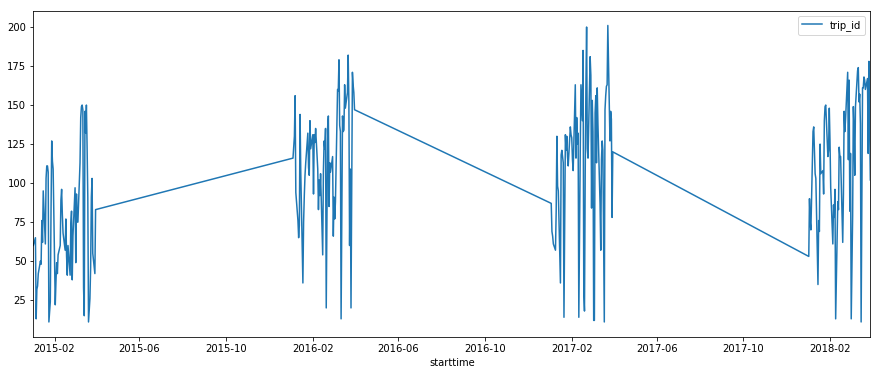

In [69]:
Final_df_md.plot()
plt.show()

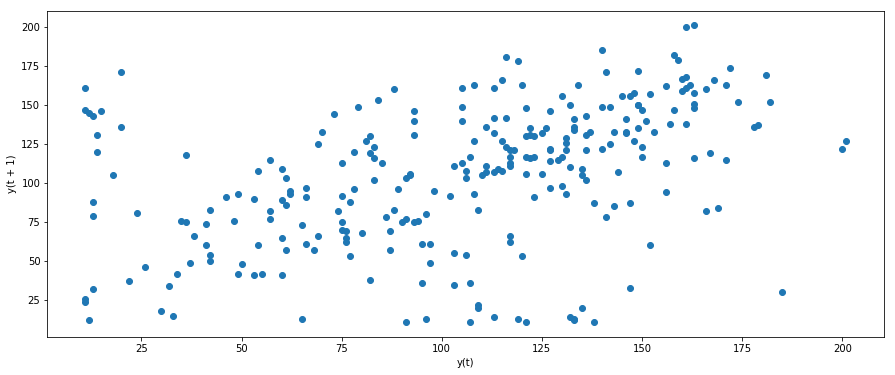

In [70]:
lag_plot(Final_df_md)
plt.show()

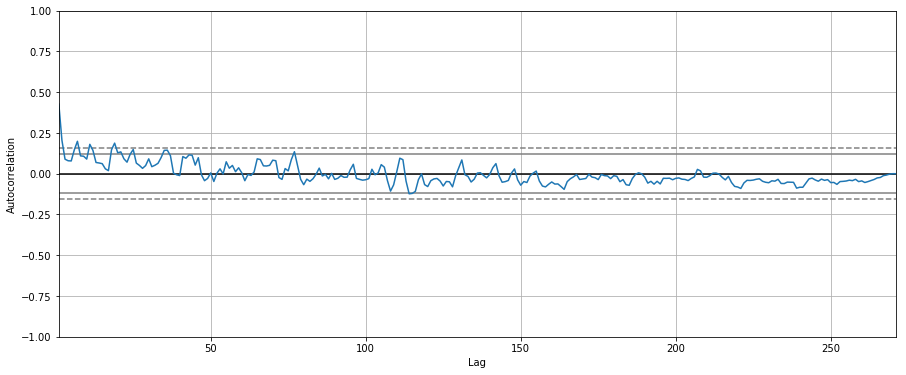

In [71]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(Final_df_md)
plt.show()

Test MSE: 2079.063


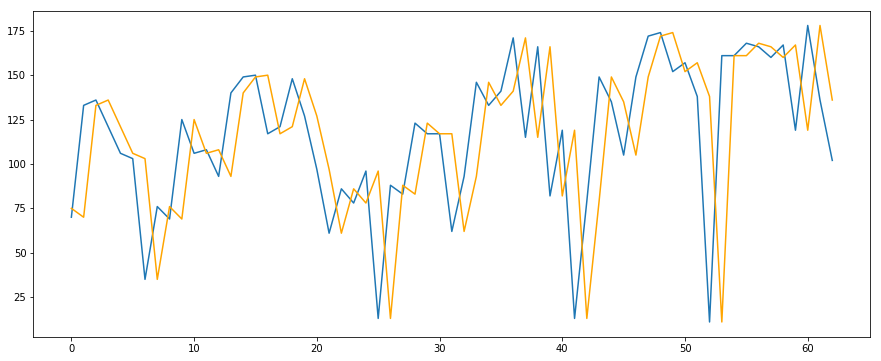

In [72]:

from sklearn.metrics import mean_squared_error
values = pd.DataFrame(Final_df_md.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-63], X[len(X)-63:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]
 
# persistence model
def model_persistence(x):
    return x
 
# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(test_y)
plt.plot(predictions, color='orange')
plt.show()

Lag: 14
Coefficients: [ 3.62408130e+01  3.80902490e-01 -4.88820830e-02 -3.66478627e-02
 -5.50921889e-03 -4.37187578e-02  1.03188821e-01  1.48477194e-01
 -4.75431103e-02  1.11256923e-01 -1.02964364e-01  1.79828989e-01
  8.87113806e-02 -1.01459119e-01  2.85875827e-02]
predicted=118.535620, expected=70.000000
predicted=116.423254, expected=133.000000
predicted=128.287144, expected=136.000000
predicted=119.717696, expected=121.000000
predicted=94.771077, expected=106.000000
predicted=111.032701, expected=103.000000
predicted=91.698709, expected=35.000000
predicted=104.971018, expected=76.000000
predicted=102.176238, expected=69.000000
predicted=104.186005, expected=125.000000
predicted=103.452388, expected=106.000000
predicted=104.697081, expected=108.000000
predicted=110.060911, expected=93.000000
predicted=105.113975, expected=140.000000
predicted=110.787639, expected=149.000000
predicted=101.844801, expected=150.000000
predicted=104.001234, expected=117.000000
predicted=103.342905, expe

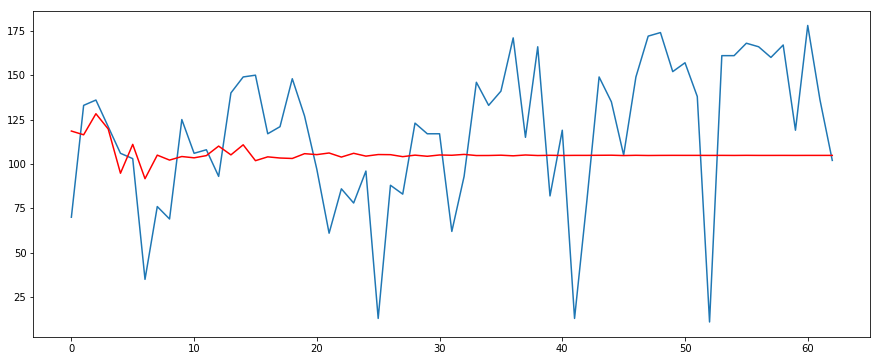

In [73]:

from statsmodels.tsa.ar_model import AR


# split dataset
X = Final_df_md.values
train, test = X[1:len(X)-63], X[len(X)-63:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
error_2 = mean_absolute_error(test, predictions)

print('Absoulte error',error_2)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

## For all data of Q1 

In [74]:


frames =[dataset_2015_Q1,dataset_2016_Q1,dataset_2017_Q1,dataset_2018_Q1]
Final_df_all=pd.concat(frames)
Final_df_all.fillna(0, inplace=True)
Final_df_all = pd.DataFrame(Final_df_all.groupby(Final_df_all['starttime'].dt.date).count()['trip_id'])


Final_df_all_md=Final_df_all
#Final_df_md['trip_id'] 


#Final_df_all_md = Final_df_all_md[Final_df_all_md.trip_id <7000]

#Final_df_md.head()
Final_df_all_md.shape
Final_df_all_md.to_excel('Final_df_all_md.xlsx')

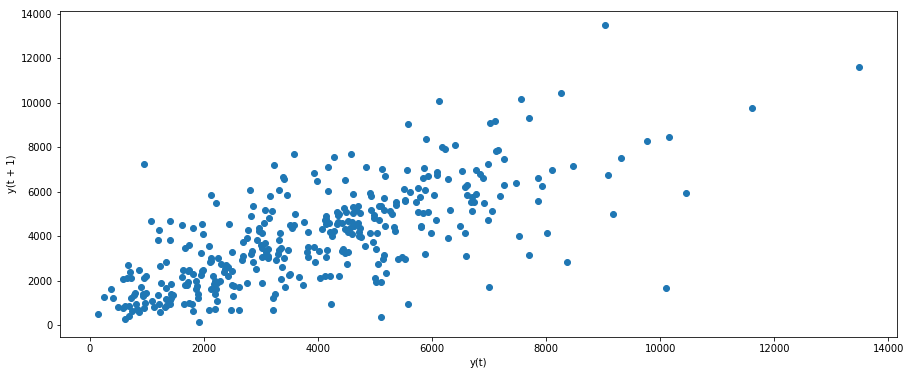

In [75]:
lag_plot(Final_df_all_md)
plt.show()

Lag: 15
Coefficients: [ 6.78769899e+02  6.55894242e-01 -6.34650498e-02  1.20939163e-01
  3.18363843e-02 -4.92200855e-02 -1.71656643e-02  1.86137630e-01
 -5.96254651e-02  4.62531141e-03 -1.06836235e-01  7.98423384e-02
 -1.56306464e-02 -1.31013918e-02  1.97027180e-01 -1.20228123e-01]
predicted=2916.696041, expected=2493.000000
predicted=4373.408865, expected=2416.000000
predicted=3771.854734, expected=2228.000000
predicted=3486.460071, expected=1093.000000
predicted=4988.685538, expected=1076.000000
predicted=2811.268208, expected=4663.000000
predicted=3217.265926, expected=5163.000000
predicted=3776.858356, expected=5173.000000
predicted=4702.389169, expected=4473.000000
predicted=4247.937075, expected=3243.000000
predicted=3615.256180, expected=1420.000000
predicted=4359.668490, expected=1206.000000
predicted=3311.381224, expected=1337.000000
predicted=3403.914409, expected=2852.000000
predicted=3584.951582, expected=3343.000000
predicted=4272.537138, expected=4137.000000
predicted=399

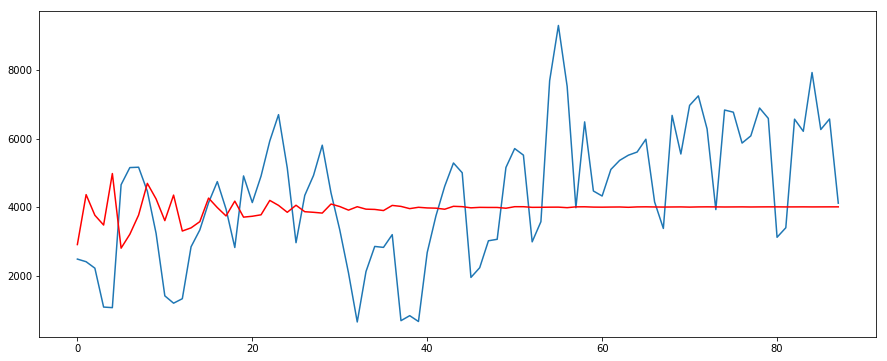

In [76]:

from statsmodels.tsa.ar_model import AR


# split dataset
X = Final_df_all_md.values
train, test = X[1:len(X)-88], X[len(X)-88:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
error_2 = mean_absolute_error(test, predictions)
print('Absoulte error',error_2)
# plot results
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()


In [77]:
Final_df_all_md.shape

(361, 1)

## ARMA model  (data =only Q1 of 2016 , prediction= march of 2016 )

In [78]:
from statsmodels.tsa.arima_model import ARMA
import statsmodels as sm

In [79]:
#data_2016_.head(70)

C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Bhavya N\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple

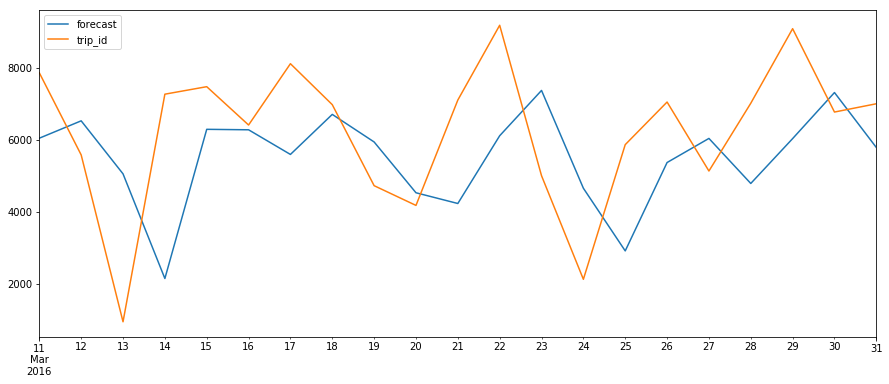

In [80]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])
#data_2016_.index = pd.Index(sm.tsa.datetools.dates_from_range('2016-01-01', '2016-03-10'))
md_2_AR=ARMA(data_2016_,(2,0)).fit()
#predict_sunspots = md.predict(data_2016_.iloc[70:,:], data_2016_.iloc[90,:], dynamic=True)
#print(predict_sunspots)
md_2_AR.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
C:\Users\Bhavya N\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple

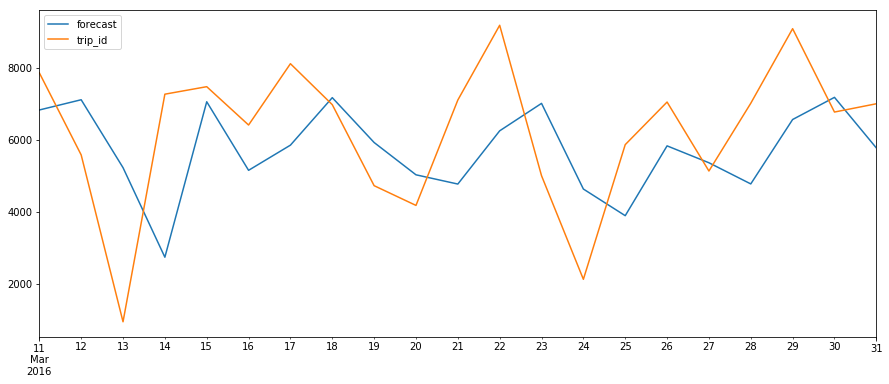

In [81]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])

md_3_AR=ARMA(data_2016_,(3,0)).fit()

md_3_AR.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


In [82]:
#md.summary()

C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


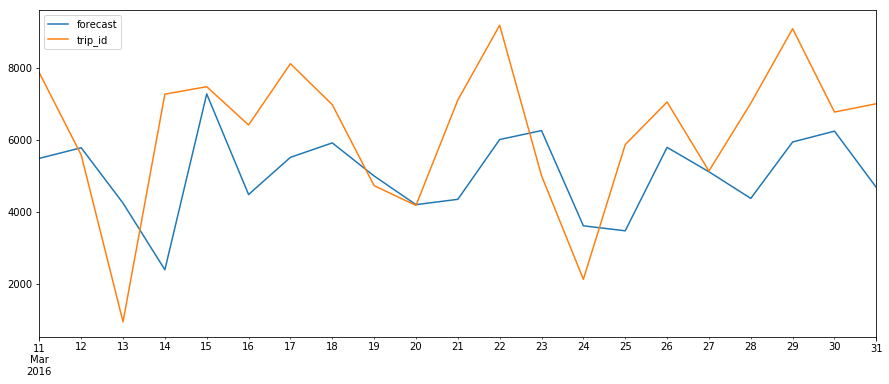

In [83]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])

md_1_MA=ARMA(data_2016_,(0,1)).fit()

md_1_MA.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


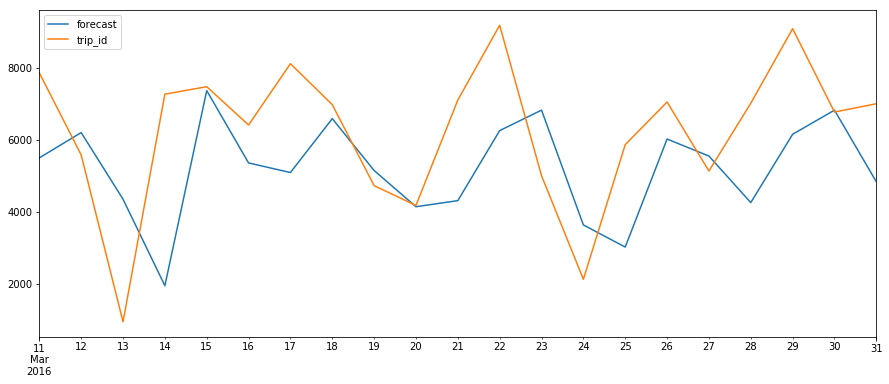

In [84]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])

md_2_MA=ARMA(data_2016_,(0,2)).fit()

md_2_MA.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


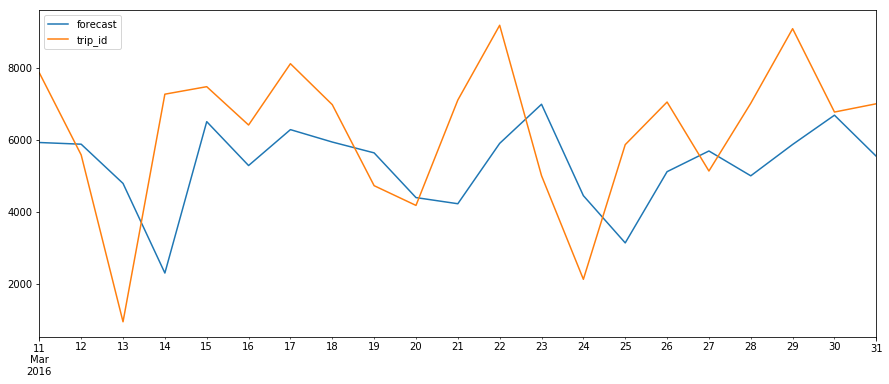

In [85]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])

md_3_MA=ARMA(data_2016_,(0,3)).fit()

md_3_MA.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


In [86]:
bic=[]
md_2_AR.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(2, 0)   Log Likelihood                -805.152
Method:                       css-mle   S.D. of innovations           1679.353
Date:                Mon, 02 Dec 2019   AIC                           1618.303
Time:                        12:45:22   BIC                           1628.347
Sample:                    01-01-2016   HQIC                          1622.355
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4349.5489    450.321      9.659      0.000    3466.935    5232.162
ar.L1.trip_id     0.6386      0.105      6.093      0.000       0.433       0.844
ar.L2.trip_id    -0.0231      0.106     -0.217      0.829      -0.231       0.185
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6663           +0.0000j            1.6663            0.0000
AR.2           26.0020           +0.0000j           26.0020            0.0000
-----------------------------------------------------------------------------
"""

In [87]:
md_3_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(3, 0)   Log Likelihood                -802.948
Method:                       css-mle   S.D. of innovations           1637.516
Date:                Mon, 02 Dec 2019   AIC                           1615.896
Time:                        12:45:22   BIC                           1628.450
Sample:                    01-01-2016   HQIC                          1620.961
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4354.5332    582.090      7.481      0.000    3213.657    5495.409
ar.L1.trip_id     0.6486      0.102      6.340      0.000       0.448       0.849
ar.L2.trip_id    -0.1576      0.121     -1.298      0.198      -0.396       0.080
ar.L3.trip_id     0.2250      0.106      2.131      0.036       0.018       0.432
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2470           -0.0000j            1.2470           -0.0000
AR.2           -0.2732           -1.8680j            1.8879           -0.2731
AR.3           -0.2732           +1.8680j            1.8879            0.2731
-----------------------------------------------------------------------------
"""

In [88]:
md_1_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(0, 1)   Log Likelihood                -808.412
Method:                       css-mle   S.D. of innovations           1741.124
Date:                Mon, 02 Dec 2019   AIC                           1622.825
Time:                        12:45:22   BIC                           1630.357
Sample:                    01-01-2016   HQIC                          1625.863
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4360.1956    290.391     15.015      0.000    3791.039    4929.352
ma.L1.trip_id     0.5975      0.076      7.833      0.000       0.448       0.747
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.6735           +0.0000j            1.6735            0.5000
-----------------------------------------------------------------------------
"""

In [89]:
md_2_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(0, 2)   Log Likelihood                -806.679
Method:                       css-mle   S.D. of innovations           1708.054
Date:                Mon, 02 Dec 2019   AIC                           1621.358
Time:                        12:45:23   BIC                           1631.401
Sample:                    01-01-2016   HQIC                          1625.410
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4359.4398    329.333     13.237      0.000    3713.959    5004.921
ma.L1.trip_id     0.6766      0.101      6.686      0.000       0.478       0.875
ma.L2.trip_id     0.1738      0.093      1.877      0.064      -0.008       0.355
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.9463           -1.4017j            2.3985           -0.4007
MA.2           -1.9463           +1.4017j            2.3985            0.4007
-----------------------------------------------------------------------------
"""

In [90]:
md_3_MA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(0, 3)   Log Likelihood                -805.390
Method:                       css-mle   S.D. of innovations           1683.724
Date:                Mon, 02 Dec 2019   AIC                           1620.780
Time:                        12:45:23   BIC                           1633.334
Sample:                    01-01-2016   HQIC                          1625.845
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4352.2139    358.422     12.143      0.000    3649.719    5054.708
ma.L1.trip_id     0.6196      0.122      5.087      0.000       0.381       0.858
ma.L2.trip_id     0.2249      0.095      2.369      0.020       0.039       0.411
ma.L3.trip_id     0.2043      0.142      1.436      0.155      -0.075       0.483
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4106           -0.0000j            1.4106           -0.5000
MA.2            0.1550           -1.8561j            1.8626           -0.2367
MA.3            0.1550           +1.8561j            1.8626            0.2367
-----------------------------------------------------------------------------
"""

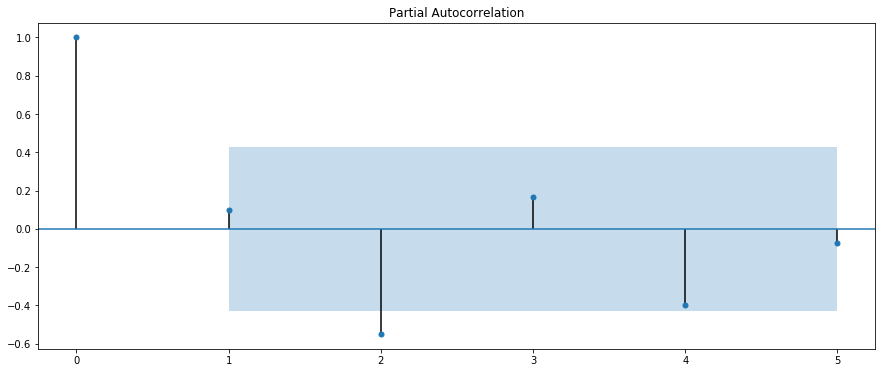

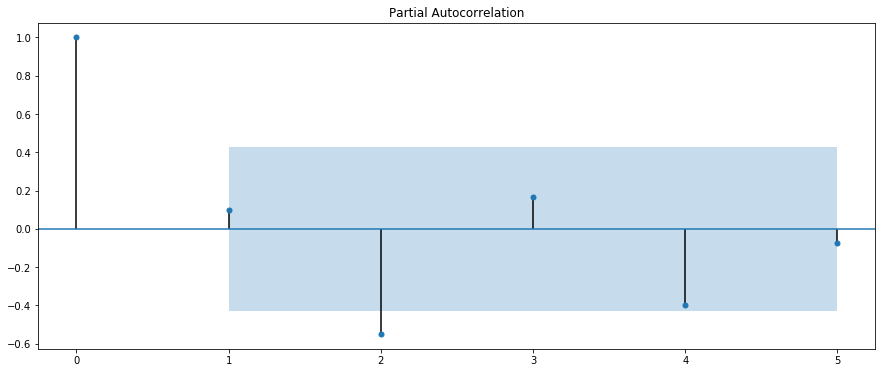

In [91]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(data_2016_.iloc[70:,:], lags= 5, alpha=0.05)

## ARMA 

C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\Bhavya N\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)


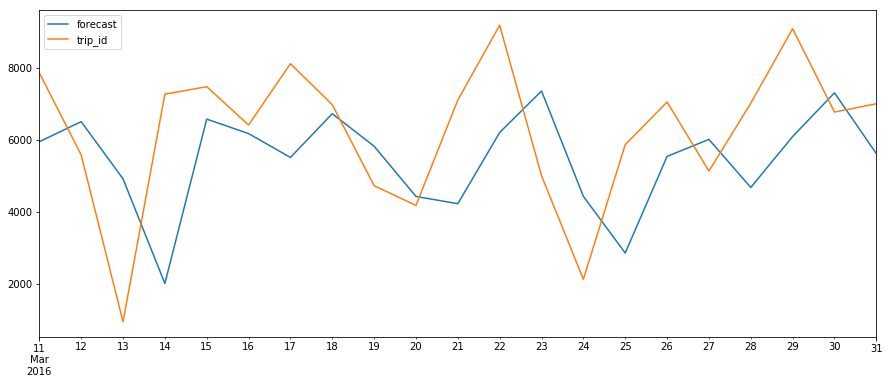

In [92]:
data_2016_ = pd.DataFrame(dataset_2016_Q1.groupby(dataset_2016_Q1['starttime'].dt.date).count()['trip_id'])

md_ARMA=ARMA(data_2016_ ,(1,1)).fit()

md_ARMA.plot_predict(start='2016-03-11', end='2016-03-31')
plt.show()


In [93]:
md_ARMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                trip_id   No. Observations:                   91
Model:                     ARMA(1, 1)   Log Likelihood                -805.099
Method:                       css-mle   S.D. of innovations           1678.335
Date:                Mon, 02 Dec 2019   AIC                           1618.197
Time:                        12:45:24   BIC                           1628.241
Sample:                    01-01-2016   HQIC                          1622.249
                         - 03-31-2016                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4349.8795    430.338     10.108      0.000    3506.433    5193.326
ar.L1.trip_id     0.5492      0.215      2.551      0.012       0.127       0.971
ma.L1.trip_id     0.1184      0.294      0.402      0.688      -0.458       0.695
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8209           +0.0000j            1.8209            0.0000
MA.1           -8.4461           +0.0000j            8.4461            0.5000
-----------------------------------------------------------------------------
"""

In [94]:
bic.append(md_2_AR.bic)
bic.append(md_3_AR.bic)
bic.append(md_1_MA.bic)
bic.append(md_2_MA.bic)
bic.append(md_3_MA.bic)
bic.append(md_ARMA.bic)



In [95]:
bic

[1628.346811853666,
 1628.4501226009702,
 1630.3571287614154,
 1631.4014670760737,
 1633.3343514759576,
 1628.240794934142]

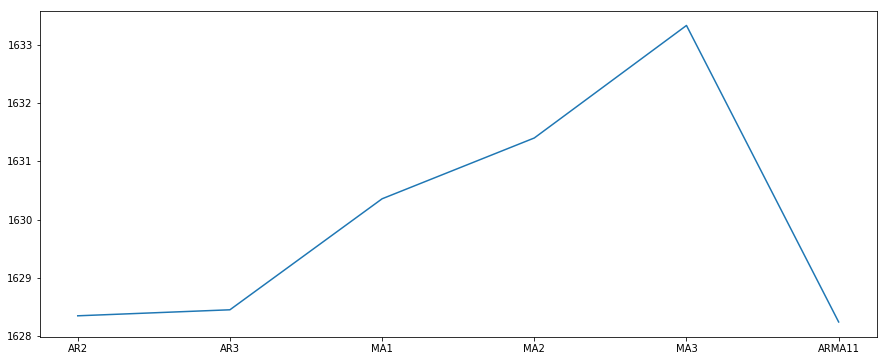

In [96]:
#xtickslabel=[AR2,AR3,MA1,MA2,MA3,ARMA11]
plt.xticks(np.arange(6), ('AR2','AR3','MA1','MA2','MA3','ARMA11'))
plt.plot(bic)

In [ ]:
data_2016_.head()

In [97]:
# Create Training and Test
train = data_2016_[:36]
test = diff_Data_2015[36:]
fc,fc_series = modelARIMA(train,test,0,1,2)
auto_arima(diff_Data_2015)
print("R square:",r2_score(test.values,fc))
print("MEan Absolute error:",mean_absolute_error(test.values,fc))

NameError: name 'diff_Data_2015' is not defined